In [25]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
from tensorflow.keras import optimizers
from glob import glob
import seaborn as sns
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive

In [26]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **In this part, the binary classification of psoriasis and similar conditions is performed.**

In [27]:
train_path = '/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Binary Dataset/train'
test_path = '/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Binary Dataset/test'

In [28]:
folders = glob('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Binary Dataset/train/*')
print(len(folders))

2


In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [30]:
test_datagen = ImageDataGenerator(
    rescale=1./255)

In [31]:
train_set = train_datagen.flow_from_directory(train_path,
                                                target_size = (224, 224),
                                                batch_size=32,
                                
                                                 class_mode = 'categorical')

Found 1680 images belonging to 2 classes.


In [32]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            shuffle=False,
                                            batch_size=32,
                                            class_mode = 'categorical')

Found 420 images belonging to 2 classes.


In [33]:
input_tensor=Input(shape=(224,224,3))

In [73]:
model1 = ResNet50V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in model1.layers:
  layer.tranable=True

In [74]:
x = GlobalAveragePooling2D(name='Pooling')(model1.output)
x = Flatten(name='flatten')(x)
x = Dense(100, kernel_regularizer=regularizers.l2(0.001),activation='softmax', name='fc1')(x)
x=Dropout(0.5)(x)
x = Dense(2,activation='softmax', name='fc2')(x)
model1 = Model(inputs=input_tensor, outputs=x)

In [75]:
model1.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [76]:
sgd = optimizers.SGD()
model1.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [77]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_Binary.hdf5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model1_history=model1.fit(
    train_set,
  validation_data=test_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 0.8818 - accuracy: 0.5762
Epoch 1: val_accuracy improved from -inf to 0.60952, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_Binary.hdf5
53/53 [==============================] - 46s 756ms/step - loss: 0.8818 - accuracy: 0.5762 - val_loss: 0.8798 - val_accuracy: 0.6095
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 0.8781 - accuracy: 0.6101
Epoch 2: val_accuracy improved from 0.60952 to 0.61190, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_Binary.hdf5
53/53 [==============================] - 40s 740ms/step - loss: 0.8781 - accuracy: 0.6101 - val_loss: 0.8763 - val_accuracy: 0.6119
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 0.8750 - accuracy: 0.6131
Epoch 3: val_accuracy did not improve from 0.61190
53/53 [==============================] - 39s 719ms/step 

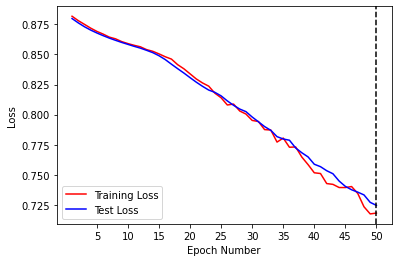

In [78]:
test_loss=model1_history.history['val_loss']
training_loss=model1_history.history['loss']
epoch_count=range(1, len(test_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, test_loss, 'b-')
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='k',label='Minimum Test Loss')
plt.xticks(np.arange(5, 51, 5))
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

In [79]:
network1 = load_model('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_Binary.hdf5')

In [80]:
test_set_evaluation = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode = 'categorical')

Found 420 images belonging to 2 classes.


In [81]:
network1.evaluate(test_set_evaluation, steps=len(test_set_evaluation))

420/420 [==============================] - 12s 24ms/step - loss: 0.8763 - accuracy: 0.6119


[0.8762637376785278, 0.6119047403335571]

In [82]:
# Making Predictions
predictions1=network1.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
preds1=np.argmax(predictions1, axis=1)

420/420 [==============================] - 9s 19ms/step


0.611904761904762

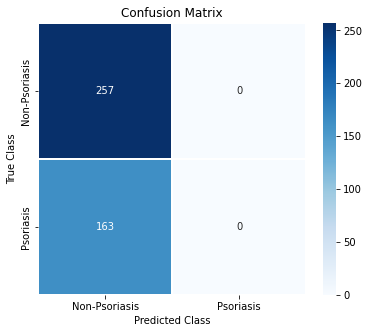

In [83]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds1)
ax=plt.figure(figsize=(6,5))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis']); ax.yaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis'])
from sklearn.metrics import accuracy_score
accuracy_score(test_set_evaluation.classes, preds1)

In [ ]:
model2 = ResNet101V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in model2.layers:
  layer.tranable=True

In [ ]:
x = GlobalAveragePooling2D(name='Pooling')(model2.output)
x = Flatten(name='flatten')(x)
x=Dropout(0.5)(x)
x = Dense(2,activation='softmax', name='fc2')(x)
model2 = Model(inputs=input_tensor, outputs=x)

In [ ]:
model2.summary()

In [ ]:
model2.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet101V2_Binary.hdf5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model2_history=model2.fit(
    train_set,
  validation_data=test_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

In [ ]:
network2 = load_model('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet101V2_Binary.hdf5')

In [ ]:
test_loss=model2_history.history['val_loss']
training_loss=model2_history.history['loss']
epoch_count=range(1, len(test_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, test_loss, 'b-')
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='k',label='Minimum Test Loss')
plt.xticks(np.arange(5, 51, 5))
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

In [ ]:
network2.evaluate(test_set_evaluation, steps=len(test_set_evaluation))

In [ ]:
# Making Predictions
predictions2=network2.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
preds2=np.argmax(predictions2, axis=1)

In [ ]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds2)
ax=plt.figure(figsize=(6,5))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis']); ax.yaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis'])
from sklearn.metrics import accuracy_score
accuracy_score(test_set_evaluation.classes, preds2)

In [ ]:
model3 = ResNet152V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in model3.layers:
  layer.tranable=True

In [ ]:
x = GlobalAveragePooling2D(name='Pooling')(model3.output)
x = Flatten(name='flatten')(x)
x=Dropout(0.5)(x)
x = Dense(2,activation='softmax', name='fc2')(x)
model3 = Model(inputs=input_tensor, outputs=x)

In [ ]:
model3.summary()

In [ ]:
model3.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet152V2_Binary.hdf5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model3_history=model3.fit(
    train_set,
  validation_data=test_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

In [ ]:
network3 = load_model('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet152V2_Binary.hdf5')

In [ ]:
test_loss=model3_history.history['val_loss']
training_loss=model3_history.history['loss']
epoch_count=range(1, len(test_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, test_loss, 'b-')
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='k',label='Minimum Test Loss')
plt.xticks(np.arange(5, 51, 5))
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

In [ ]:
network3.evaluate(test_set_evaluation, steps=len(test_set_evaluation))

In [ ]:
# Making Predictions
predictions3=network3.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
preds3=np.argmax(predictions3, axis=1)

In [ ]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds3)
ax=plt.figure(figsize=(6,5))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis']); ax.yaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis'])
from sklearn.metrics import accuracy_score
accuracy_score(test_set_evaluation.classes, preds3)

In [ ]:
networks = [network1, network2, network3]
preds_1 = [network.predict(test_set_evaluation) for network in networks]
preds_1=np.array(preds_1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds_1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(test_set.classes, wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                          'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " and w3=", max_acc_row[2])    

In [ ]:
networks = [network1, network2, network3]
preds = [network.predict(test_set_evaluation) for network in networks]
preds=np.array(preds)
ideal_weights = [max_acc_row[0], max_acc_row[1], max_acc_row[2]] 
np.save('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/weights_binary.npy', ideal_weights)
#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(test_set.classes, ideal_weighted_ensemble_prediction)

In [ ]:
cf_matrix=confusion_matrix(test_set_evaluation.classes, ideal_weighted_ensemble_prediction)
ax=plt.figure(figsize=(6,5))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis']); ax.yaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis'])

### **In this part, the multi-class classification of variants of psoriasis is performed.**

In [ ]:
train_path = '/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Multi Class Dataset/train'
test_path = '/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Multi Class Dataset/test'

In [ ]:
folders = glob('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Multi Class Dataset/train/*')
print(len(folders))

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255)

In [ ]:
train_set = train_datagen.flow_from_directory(train_path,
                                                target_size = (224, 224),
                                                batch_size=32,
                                
                                                 class_mode = 'categorical')

In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            shuffle=False,
                                            batch_size=32,
                                            class_mode = 'categorical')

In [ ]:
input_tensor=Input(shape=(224,224,3))

In [ ]:
model1 = ResNet50V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in model1.layers:
  layer.tranable=True

In [ ]:
x = GlobalAveragePooling2D(name='Pooling')(model1.output)
x = Flatten(name='flatten')(x)
x=Dropout(0.5)(x)
x = Dense(500, kernel_regularizer=regularizers.l2(0.001),activation='softmax', name='fc1')(x)
x=Dropout(0.5)(x)
x = Dense(2,activation='softmax', name='fc2')(x)
model1 = Model(inputs=input_tensor, outputs=x)

In [ ]:
model1.summary()

In [ ]:
model1.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_MultiClass.hdf5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model1_history=model1.fit(
    train_set,
  validation_data=test_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

In [ ]:
test_loss=model1_history.history['val_loss']
training_loss=model1_history.history['loss']
epoch_count=range(1, len(test_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, test_loss, 'b-')
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='k',label='Minimum Test Loss')
plt.xticks(np.arange(5, 51, 5))
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

In [ ]:
network1 = load_model('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_MultiClass.hdf5')

In [ ]:
test_set_evaluation = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode = 'categorical')

In [ ]:
test_set_evaluation = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode = 'categorical')
network1.evaluate(test_set_evaluation, steps=len(test_set_evaluation))

In [ ]:
# Making Predictions
predictions1=network1.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
preds1=np.argmax(predictions1, axis=1)

In [ ]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds1)
ax=plt.figure(figsize=(12,10))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular']); ax.yaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular'])
from sklearn.metrics import accuracy_score
accuracy_score(test_set_evaluation.classes, preds1)

In [ ]:
model2 = ResNet101V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in model2.layers:
  layer.tranable=True

In [ ]:
x = GlobalAveragePooling2D(name='Pooling')(model2.output)
x = Flatten(name='flatten')(x)
x=Dropout(0.5)(x)
x = Dense(500, kernel_regularizer=regularizers.l2(0.001),activation='softmax', name='fc1')(x)
x=Dropout(0.5)(x)
x = Dense(2,activation='softmax', name='fc2')(x)
model2 = Model(inputs=input_tensor, outputs=x)

In [ ]:
model2.summary()

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet101V2_MultiClass.hdf5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model2_history=model2.fit(
    train_set,
  validation_data=test_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

In [ ]:
network2 = load_model('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet101V2_MultiClass.hdf5')

In [ ]:
test_loss=model2_history.history['val_loss']
training_loss=model2_history.history['loss']
epoch_count=range(1, len(test_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, test_loss, 'b-')
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='k',label='Minimum Test Loss')
plt.xticks(np.arange(5, 51, 5))
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

In [ ]:
network2.evaluate(test_set_evaluation, steps=len(test_set_evaluation))

In [ ]:
# Making Predictions
predictions2=network2.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
preds2=np.argmax(predictions2, axis=1)

In [ ]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds2)
ax=plt.figure(figsize=(12,10))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular']); ax.yaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular'])
from sklearn.metrics import accuracy_score
accuracy_score(test_set_evaluation.classes, preds2)

In [ ]:
model3 = ResNet152V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in model3.layers:
  layer.tranable=True

In [ ]:
x = GlobalAveragePooling2D(name='Pooling')(model3.output)
x = Flatten(name='flatten')(x)
x=Dropout(0.5)(x)
x = Dense(500, kernel_regularizer=regularizers.l2(0.001),activation='softmax', name='fc1')(x)
x=Dropout(0.5)(x)
x = Dense(2,activation='softmax', name='fc2')(x)
model3 = Model(inputs=input_tensor, outputs=x)

In [ ]:
model3.summary()

In [ ]:
model3.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet152V2_MultiClass.hdf5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model3_history=model3.fit(
    train_set,
  validation_data=test_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

In [ ]:
network3 = load_model('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet152V2_MultiClass.hdf5')

In [ ]:
test_loss=model3_history.history['val_loss']
training_loss=model3_history.history['loss']
epoch_count=range(1, len(test_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, test_loss, 'b-')
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='k',label='Minimum Test Loss')
plt.xticks(np.arange(5, 51, 5))
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

In [ ]:
network3.evaluate(test_set_evaluation, steps=len(test_set_evaluation))

In [ ]:
# Making Predictions
predictions3=network3.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
preds3=np.argmax(predictions3, axis=1)

In [ ]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds3)
ax=plt.figure(figsize=(12,10))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular']); ax.yaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular'])
from sklearn.metrics import accuracy_score
accuracy_score(test_set_evaluation.classes, preds3)

In [ ]:
networks = [network1, network2, network3]
preds_1 = [network.predict(test_set_evaluation) for network in networks]
preds_1=np.array(preds_1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds_1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(test_set.classes, wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                          'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " and w3=", max_acc_row[2])    

In [ ]:
networks = [network1, network2, network3]
preds = [network.predict(test_set_evaluation) for network in networks]
preds=np.array(preds)
ideal_weights = [max_acc_row[0], max_acc_row[1], max_acc_row[2]] 
np.save('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/weights_MultiClass.npy', ideal_weights)
#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(test_set.classes, ideal_weighted_ensemble_prediction)

In [ ]:
cf_matrix=confusion_matrix(test_set_evaluation.classes, ideal_weighted_ensemble_prediction)
ax=plt.figure(figsize=(12,10))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular']); ax.yaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular'])